# 絵画データセットの探索的データ分析（EDA）

このノートブックでは、**画像ファイル名に基づいて作成されたデータセット**（`dataset_from_images.csv`）に対する包括的な探索的データ分析を実施します。

## データセットの説明

- **データソース**: `data/filtered_data/dataset_from_images.csv`
- **作成方法**: `paintings_images`ディレクトリにある画像ファイル名（Object_ID）をもとに、`raw_data/MetObjects.csv`から対応するデータを抽出
- **データ行数**: 5,396行（画像ファイル数に基づく）
- **データ列数**: 54列（MetObjects.csvの全列）

## 分析の目的

1. データの概要と品質の把握
2. 文化圏、年代、メディアなどの分布分析
3. アーティスト情報の分析
4. JSON形式データ（タグ、アーティスト、測定値）の解析
5. 画像データの分析
6. 変数間の関係性の探索


## セクション0: 環境設定とデータ読み込み


In [31]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from pathlib import Path
from collections import Counter

# 日本語フォントの設定（グラフで日本語を表示する場合）
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
sns.set_palette("husl")

# 警告の非表示
warnings.filterwarnings('ignore')

# 表示オプション
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

print("ライブラリの読み込み完了")


ライブラリの読み込み完了


In [ ]:
# データの読み込み
# 画像ファイル名に基づいて作成されたデータセットを使用
data_path = Path("../data/filtered_data/dataset_from_images.csv")
df = pd.read_csv(data_path, low_memory=False)

print(f"データの形状: {df.shape}")
print(f"\nデータの読み込み完了: {len(df):,}行 × {len(df.columns)}列")
print(f"\nデータソース: {data_path}")
print("このデータセットは、paintings_imagesディレクトリにある画像ファイル名（Object_ID）")
print("をもとに、raw_data/MetObjects.csvから抽出されたデータです。")


データの形状: (2290, 63)

データの読み込み完了: 2,290行 × 63列

データソース: ..\data\filtered_data\paintings_complete_dataset.csv
このデータセットは、paintings_imagesディレクトリにある画像ファイル名（Object_ID）
をもとに、raw_data/MetObjects.csvから抽出されたデータです。


In [ ]:
# 共通ユーティリティ関数の定義

def print_section_header(title):
    """セクション見出しを表示"""
    print("=" * 60)
    print(title)
    print("=" * 60)

def plot_top_categories(series, title, xlabel="件数", top_n=15, figsize=(14, 8)):
    """上位カテゴリの横棒グラフを描画"""
    top_values = series.head(top_n)
    plt.figure(figsize=figsize)
    labels = [str(label)[:50] + '...' if len(str(label)) > 50 else str(label) 
              for label in top_values.index]
    plt.barh(range(len(top_values)), top_values.values)
    plt.yticks(range(len(top_values)), labels)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_pie_chart(series, title, top_n=10, figsize=(10, 10)):
    """上位カテゴリの円グラフを描画"""
    top_values = series.head(top_n)
    plt.figure(figsize=figsize)
    plt.pie(top_values.values, labels=top_values.index, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

def analyze_categorical_column(df, column_name, top_n=20):
    """カテゴリ変数の分析を実行"""
    if column_name not in df.columns:
        print(f"警告: 列 '{column_name}' が見つかりません")
        return None
    
    counts = df[column_name].value_counts()
    percent = (counts / len(df)) * 100
    
    missing_count = df[column_name].isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    
    result = {
        'counts': counts,
        'percent': percent,
        'missing_count': missing_count,
        'missing_percent': missing_percent,
        'unique_count': len(counts)
    }
    
    print(f"\n{column_name}の概要（{len(counts)}種類）")
    print(f"欠損値: {missing_count:,}件 ({missing_percent:.1f}%)")
    print(f"\n上位{top_n}:")
    top_df = pd.DataFrame({
        '件数': counts.head(top_n),
        '割合(%)': percent.head(top_n).round(2)
    })
    print(top_df)
    
    return result

def plot_distribution(series, title, xlabel, bins=50, figsize=(10, 6)):
    """分布のヒストグラムを描画"""
    plt.figure(figsize=figsize)
    plt.hist(series.dropna(), bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel('件数')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# JSON解析関数（共通）

def parse_json_column(json_str, key=None):
    """
    JSON列を解析してリストを返す
    
    Args:
        json_str: JSON文字列または既にパースされたオブジェクト
        key: 抽出するキー（例: 'term' for tags）
    
    Returns:
        解析されたデータのリスト
    """
    if pd.isna(json_str) or json_str == '':
        return []
    try:
        if isinstance(json_str, str):
            data = json.loads(json_str)
        else:
            data = json_str
        
        if isinstance(data, list):
            if key:
                return [item.get(key, '') for item in data if isinstance(item, dict) and key in item]
            return data
        elif isinstance(data, dict):
            if key:
                return [data.get(key, '')] if key in data else []
            return [data]
        else:
            return []
    except (json.JSONDecodeError, TypeError):
        return []

def parse_tags(tags_str):
    """tags列をJSONとして解析してタグリストを返す"""
    return parse_json_column(tags_str, key='term')

def parse_constituents(constituents_str):
    """constituents列をJSONとして解析してリストを返す"""
    return parse_json_column(constituents_str)

def parse_measurements(measurements_str):
    """measurements列をJSONとして解析してリストを返す"""
    return parse_json_column(measurements_str)

def extract_dimensions(measurements_data):
    """measurementsデータからHeightとWidthを抽出"""
    heights = []
    widths = []
    depths = []
    
    for measure in measurements_data:
        if isinstance(measure, dict) and 'elementMeasurements' in measure:
            elem_measure = measure['elementMeasurements']
            if isinstance(elem_measure, dict):
                if 'Height' in elem_measure:
                    try:
                        heights.append(float(elem_measure['Height']))
                    except (ValueError, TypeError):
                        pass
                if 'Width' in elem_measure:
                    try:
                        widths.append(float(elem_measure['Width']))
                    except (ValueError, TypeError):
                        pass
                if 'Depth' in elem_measure:
                    try:
                        depths.append(float(elem_measure['Depth']))
                    except (ValueError, TypeError):
                        pass
    
    return heights, widths, depths

print("共通ユーティリティ関数の定義完了")


データの基本情報
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Object_Number            2290 non-null   object 
 1   Is_Highlight             2290 non-null   bool   
 2   Is_Timeline_Work         2290 non-null   bool   
 3   Is_Public_Domain         2290 non-null   bool   
 4   Object_ID                2290 non-null   int64  
 5   Gallery_Number           572 non-null    float64
 6   Department               2290 non-null   object 
 7   AccessionYear            2290 non-null   float64
 8   Object_Name              2285 non-null   object 
 9   Title                    2290 non-null   object 
 10  Culture                  0 non-null      float64
 11  Period                   0 non-null      float64
 12  Dynasty                  0 non-null      float64
 13  Reign                    0 non-null      float64
 14  Portfolio      

In [ ]:
# データの基本情報
print_section_header("データの基本情報")
df.info()


,Object_Number,Is_Highlight,Is_Timeline_Work,Is_Public_Domain,Object_ID,Gallery_Number,Department,AccessionYear,Object_Name,Title,Culture,Period,Dynasty,Reign,Portfolio,Constituent_ID,Artist_Role,Artist_Prefix,Artist_Display_Name,Artist_Display_Bio,Artist_Suffix,Artist_Alpha_Sort,Artist_Nationality,Artist_Begin_Date,Artist_End_Date,Artist_Gender,Artist_ULAN_URL,Artist_Wikidata_URL,Object_Date,Object_Begin_Date,Object_End_Date,Medium,Dimensions,Credit_Line,Geography_Type,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River,Classification,Rights_and_Reproduction,Link_Resource,Object_Wikidata_URL,Metadata_Date,Repository,Tags,Tags_AAT_URL,Tags_Wikidata_URL,primaryImage,primaryImageSmall,additionalImages,constituents,tags,measurements,galleryNumber,objectWikidata_URL,image_downloaded
0,76.10,False,True,True,435572,NaN,European Paintings,1876.0,"Painting, part of an altarpiece",Saint Giles with Christ Triumphant over Satan and the Mission of the Apostles,NaN,NaN,NaN,NaN,NaN,10730,Artist,,Miguel Alcañiz (or Miquel Alcanyís),"Spanish, Valencian, active by 1408–died after 1447",,"Alcañiz, Miguel (or Miquel Alcanyís)",Spanish,1408,1447,NaN,http://vocab.getty.edu/page/ulan/500121294,https://www.wikidata.org/wiki/Q14089634,ca. 1408,1403,1413,"Tempera on wood, gold ground","Overall 59 5/8 x 39 1/2 in. (151.4 x 100.3 cm); upper left panel, painted surface 24 1/8 x 16 7/...","Gift of J. Bruyn Andrews, 1876",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search/435572,https://www.wikidata.org/wiki/Q19911993,NaN,"Metropolitan Museum of Art, New York, NY",Apostles|Saints|Christ,http://vocab.getty.edu/page/aat/300343837|http://vocab.getty.edu/page/aat/300150555|http://vocab...,https://www.wikidata.org/wiki/Q43412|https://www.wikidata.org/wiki/Q43115|https://www.wikidata.o...,https://images.metmuseum.org/CRDImages/ep/original/DP102155.jpg,https://images.metmuseum.org/CRDImages/ep/web-large/DP102155.jpg,[],"[{""constituentID"": 107301, ""role"": ""Artist"", ""name"": ""Miguel Alcañiz (or Miquel Alcanyís)"", ""con...","[{""term"": ""Apostles"", ""AAT_URL"": ""http://vocab.getty.edu/page/aat/300343837"", ""Wikidata_URL"": ""h...","[{""elementName"": ""Overall"", ""elementDescription"": null, ""elementMeasurements"": {""Height"": 151.4,...",NaN,https://www.wikidata.org/wiki/Q19911993,True
1,1985.5,False,False,True,435573,NaN,European Paintings,1985.0,Painting,Flora and Zephyr,NaN,NaN,NaN,NaN,NaN,16159,Artist,,Jacopo Amigoni,"Italian, Venice 1682–1752 Madrid",,"Amigoni, Jacopo",Italian,1682,1752,NaN,http://vocab.getty.edu/page/ulan/500016473,https://www.wikidata.org/wiki/Q380897,1730s,1730,1739,Oil on canvas,84 x 58 in. (213.4 x 147.3 cm),"Purchase, Rudolph and Lentilhon G. von Fluegge Foundation Inc. Gift, 1985",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search/435573,https://www.wikidata.org/wiki/Q19912099,NaN,"Metropolitan Museum of Art, New York, NY",Goddess|Putti|Flowers|Landscapes,http://vocab.getty.edu/page/aat/300343852|http://vocab.getty.edu/page/aat/300250465|http://vocab...,https://www.wikidata.org/wiki/Q205985|https://www.wikidata.org/wiki/Q284865|https://www.wikidata...,https://images.metmuseum.org/CRDImages/ep/original/DT8028.jpg,https://images.metmuseum.org/CRDImages/ep/web-large/DT8028.jpg,[],"[{""constituentID"": 161598, ""role"": ""Artist"", ""name"": ""Jacopo Amigoni"", ""constituentULAN_URL"": ""h...","[{""term"": ""Putti"", ""AAT_URL"": ""http://vocab.getty.edu/page/aat/300250465"", ""Wikidata_URL"": ""http...","[{""elementName"": ""Overall"", ""elementDescription"": null, ""elementMeasurements"": {""Height"": 213.4,...",NaN,https://www.wikidata.org/wiki/Q19912099,True
2,12.6,False,False,True,435574,NaN,European Paintings,1912.0,"Painting, predella panel",The Crucifixion,NaN,NaN,NaN,NaN,NaN,16601,Artist,,Andrea di Bartolo,"Italian, Siena, active by 1389–died 1428 Siena",,Andrea di Bartolo,Italian,1389,1428

In [ ]:
# データの最初の数行を表示
df.head()


## セクション1: データ概要


In [48]:
# データ形状の確認
print(f"行数: {df.shape[0]:,}")
print(f"列数: {df.shape[1]}")
print(f"\n列名一覧:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


行数: 2,290
列数: 63

列名一覧:
 1. Object_Number
 2. Is_Highlight
 3. Is_Timeline_Work
 4. Is_Public_Domain
 5. Object_ID
 6. Gallery_Number
 7. Department
 8. AccessionYear
 9. Object_Name
10. Title
11. Culture
12. Period
13. Dynasty
14. Reign
15. Portfolio
16. Constituent_ID
17. Artist_Role
18. Artist_Prefix
19. Artist_Display_Name
20. Artist_Display_Bio
21. Artist_Suffix
22. Artist_Alpha_Sort
23. Artist_Nationality
24. Artist_Begin_Date
25. Artist_End_Date
26. Artist_Gender
27. Artist_ULAN_URL
28. Artist_Wikidata_URL
29. Object_Date
30. Object_Begin_Date
31. Object_End_Date
32. Medium
33. Dimensions
34. Credit_Line
35. Geography_Type
36. City
37. State
38. County
39. Country
40. Region
41. Subregion
42. Locale
43. Locus
44. Excavation
45. River
46. Classification
47. Rights_and_Reproduction
48. Link_Resource
49. Object_Wikidata_URL
50. Metadata_Date
51. Repository
52. Tags
53. Tags_AAT_URL
54. Tags_Wikidata_URL
55. primaryImage
56. primaryImageSmall
57. additionalImages
58. constituents
59

In [49]:
# データ型の確認
print("=" * 60)
print("データ型の分布")
print("=" * 60)
print(df.dtypes.value_counts())
print("\n各列のデータ型:")
print(df.dtypes)


データ型の分布
object     35
float64    20
bool        4
int64       4
Name: count, dtype: int64

各列のデータ型:
Object_Number               object
Is_Highlight                  bool
Is_Timeline_Work              bool
Is_Public_Domain              bool
Object_ID                    int64
Gallery_Number             float64
Department                  object
AccessionYear              float64
Object_Name                 object
Title                       object
Culture                    float64
Period                     float64
Dynasty                    float64
Reign                      float64
Portfolio                  float64
Constituent_ID               int64
Artist_Role                 object
Artist_Prefix               object
Artist_Display_Name         object
Artist_Display_Bio          object
Artist_Suffix               object
Artist_Alpha_Sort           object
Artist_Nationality          object
Artist_Begin_Date           object
Artist_End_Date             object
Artist_Gender            

In [50]:
# 欠損値の確認
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    '欠損数': missing_data,
    '欠損率(%)': missing_percent
})
missing_df = missing_df[missing_df['欠損数'] > 0].sort_values('欠損数', ascending=False)

print("=" * 60)
print(f"欠損値の概要（{len(missing_df)}列に欠損値あり）")
print("=" * 60)
print(missing_df.head(20))


欠損値の概要（36列に欠損値あり）
                          欠損数      欠損率(%)
Period                   2290  100.000000
Culture                  2290  100.000000
Reign                    2290  100.000000
Dynasty                  2290  100.000000
Region                   2290  100.000000
Subregion                2290  100.000000
Portfolio                2290  100.000000
Geography_Type           2290  100.000000
Country                  2290  100.000000
County                   2290  100.000000
State                    2290  100.000000
City                     2290  100.000000
galleryNumber            2290  100.000000
Metadata_Date            2290  100.000000
Locale                   2290  100.000000
Locus                    2290  100.000000
River                    2290  100.000000
Excavation               2290  100.000000
Rights_and_Reproduction  2288   99.912664
Artist_Gender            2239   97.772926


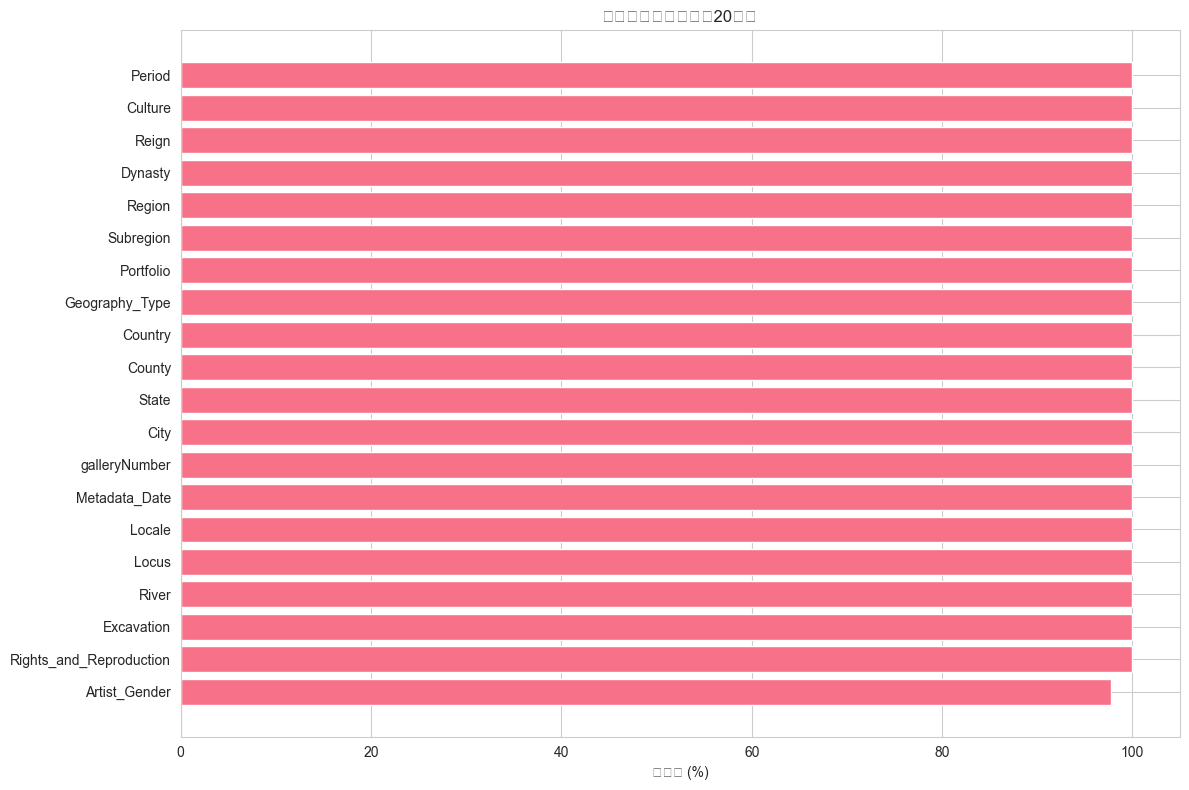

In [51]:
# 欠損値の可視化（上位20列）
plt.figure(figsize=(12, 8))
top_missing = missing_df.head(20)
plt.barh(range(len(top_missing)), top_missing['欠損率(%)'])
plt.yticks(range(len(top_missing)), top_missing.index)
plt.xlabel('欠損率 (%)')
plt.title('欠損値の割合（上位20列）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [52]:
# 数値列の基本統計量
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("=" * 60)
print("数値列の基本統計量")
print("=" * 60)
if len(numeric_cols) > 0:
    print(df[numeric_cols].describe())
else:
    print("数値列が見つかりませんでした")


数値列の基本統計量
           Object_ID  Gallery_Number  AccessionYear  Culture  Period  Dynasty  \
count    2290.000000      572.000000    2290.000000      0.0     0.0      0.0   
mean   450084.108297      778.103147    1953.110480      NaN     NaN      NaN   
std     63553.316120      147.812626      40.019038      NaN     NaN      NaN   
min    435572.000000       10.000000    1871.000000      NaN     NaN      NaN   
25%    436420.500000      802.000000    1925.000000      NaN     NaN      NaN   
50%    437168.500000      809.500000    1949.000000      NaN     NaN      NaN   
75%    437902.750000      824.000000    1986.000000      NaN     NaN      NaN   
max    894279.000000      965.000000    2023.000000      NaN     NaN      NaN   

       Reign  Portfolio  Constituent_ID  Object_Begin_Date  Object_End_Date  \
count    0.0        0.0    2.290000e+03        2290.000000      2290.000000   
mean     NaN        NaN    1.072970e+08        1698.159389      1711.317467   
std      NaN        NaN

## セクション2: 文化圏分析


In [53]:
# 文化圏（Culture）の分析
culture_counts = df['Culture'].value_counts()
culture_percent = (culture_counts / len(df)) * 100

print("=" * 60)
print(f"文化圏の概要（{len(culture_counts)}種類の文化圏）")
print("=" * 60)
print(f"欠損値: {df['Culture'].isnull().sum():,}件 ({df['Culture'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n上位20の文化圏:")
culture_top20 = pd.DataFrame({
    '作品数': culture_counts.head(20),
    '割合(%)': culture_percent.head(20)
})
print(culture_top20)


文化圏の概要（0種類の文化圏）
欠損値: 2,290件 (100.0%)

上位20の文化圏:
Empty DataFrame
Columns: [作品数, 割合(%)]
Index: []


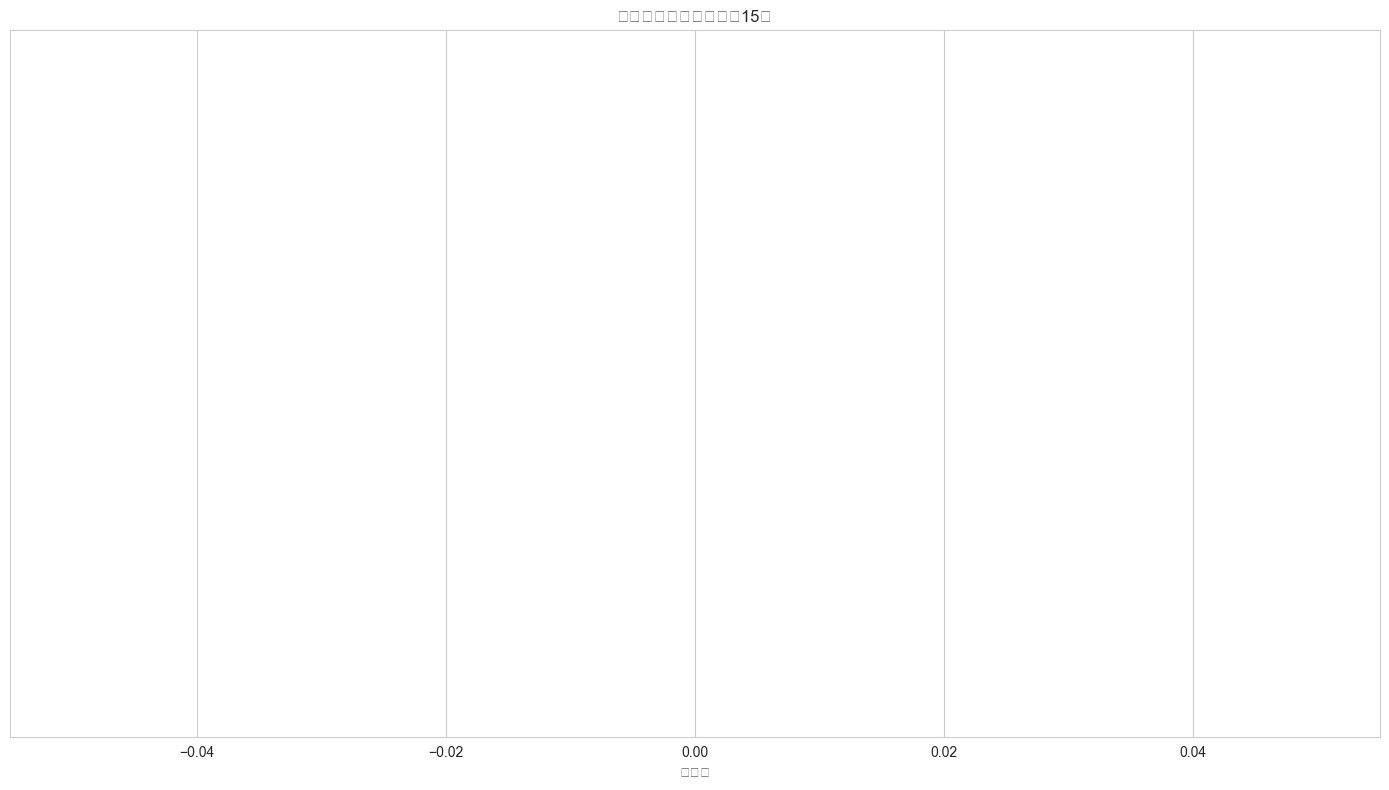

In [54]:
# 文化圏の分布を可視化（上位15）
plt.figure(figsize=(14, 8))
top_cultures = culture_counts.head(15)
plt.barh(range(len(top_cultures)), top_cultures.values)
plt.yticks(range(len(top_cultures)), top_cultures.index)
plt.xlabel('作品数')
plt.title('文化圏別作品数（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


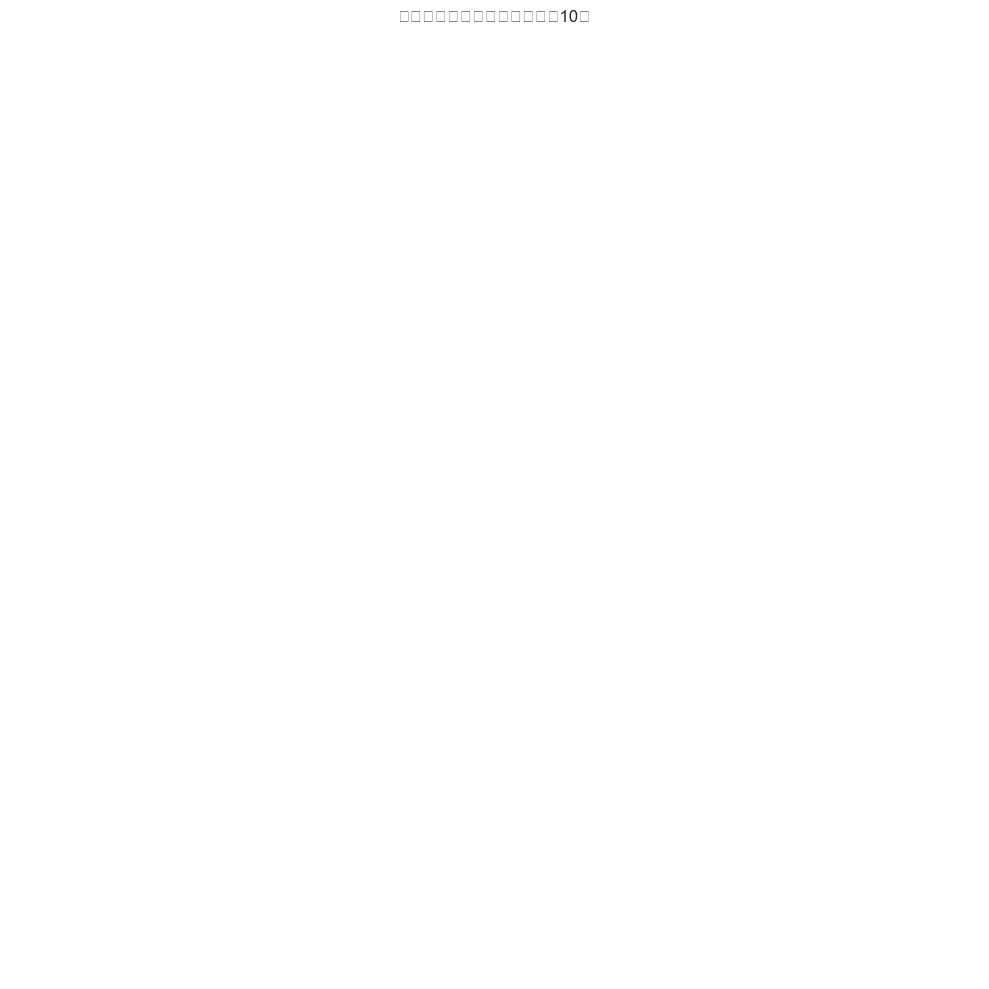

In [55]:
# 文化圏の割合を円グラフで表示（上位10）
plt.figure(figsize=(10, 10))
top_cultures_pie = culture_counts.head(10)
plt.pie(top_cultures_pie.values, labels=top_cultures_pie.index, autopct='%1.1f%%', startangle=90)
plt.title('文化圏別作品数の割合（上位10）')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [56]:
# 文化圏とDepartmentのクロス集計
culture_dept_cross = pd.crosstab(df['Culture'], df['Department'], margins=True)
print("=" * 60)
print("文化圏とDepartmentのクロス集計（上位20文化圏）")
print("=" * 60)
print(culture_dept_cross.loc[culture_counts.head(20).index].sort_values('All', ascending=False))


文化圏とDepartmentのクロス集計（上位20文化圏）


KeyError: 'All'

## セクション3: 年代分析


In [58]:
# 年代データの確認
print("=" * 60)
print("年代データの概要")
print("=" * 60)

# Object_Begin_DateとObject_End_Dateの統計
print("\nObject_Begin_Date:")
print(f"  欠損値: {df['Object_Begin_Date'].isnull().sum():,}件")
print(f"  最小値: {df['Object_Begin_Date'].min()}")
print(f"  最大値: {df['Object_Begin_Date'].max()}")
print(f"  平均値: {df['Object_Begin_Date'].mean():.1f}")

print("\nObject_End_Date:")
print(f"  欠損値: {df['Object_End_Date'].isnull().sum():,}件")
print(f"  最小値: {df['Object_End_Date'].min()}")
print(f"  最大値: {df['Object_End_Date'].max()}")
print(f"  平均値: {df['Object_End_Date'].mean():.1f}")


年代データの概要

Object_Begin_Date:
  欠損値: 0件
  最小値: 1200
  最大値: 1928
  平均値: 1698.2

Object_End_Date:
  欠損値: 0件
  最小値: 1239
  最大値: 1999
  平均値: 1711.3


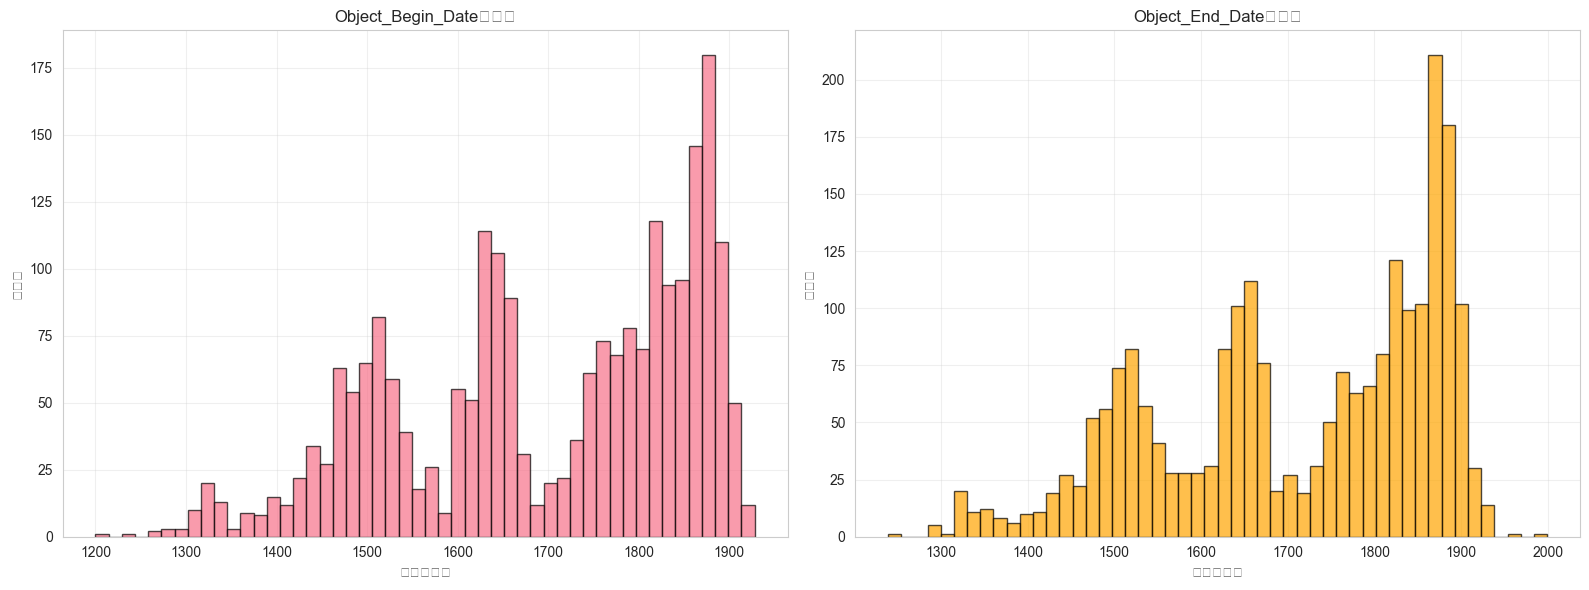

In [59]:
# 作品制作年代の分布（ヒストグラム）
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Object_Begin_Dateの分布
valid_begin_dates = df['Object_Begin_Date'].dropna()
axes[0].hist(valid_begin_dates, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('制作開始年')
axes[0].set_ylabel('作品数')
axes[0].set_title('Object_Begin_Dateの分布')
axes[0].grid(True, alpha=0.3)

# Object_End_Dateの分布
valid_end_dates = df['Object_End_Date'].dropna()
axes[1].hist(valid_end_dates, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('制作終了年')
axes[1].set_ylabel('作品数')
axes[1].set_title('Object_End_Dateの分布')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [60]:
# アーティストの活動期間の分析
print("=" * 60)
print("アーティスト活動期間の概要")
print("=" * 60)

print("\nArtist_Begin_Date:")
print(f"  欠損値: {df['Artist_Begin_Date'].isnull().sum():,}件")
if df['Artist_Begin_Date'].notna().any():
    print(f"  最小値: {df['Artist_Begin_Date'].min()}")
    print(f"  最大値: {df['Artist_Begin_Date'].max()}")

print("\nArtist_End_Date:")
print(f"  欠損値: {df['Artist_End_Date'].isnull().sum():,}件")
if df['Artist_End_Date'].notna().any():
    print(f"  最小値: {df['Artist_End_Date'].min()}")
    print(f"  最大値: {df['Artist_End_Date'].max()}")


アーティスト活動期間の概要

Artist_Begin_Date:
  欠損値: 0件
  最小値:           
  最大値: 1908      

Artist_End_Date:
  欠損値: 0件
  最小値:           
  最大値: 1981      


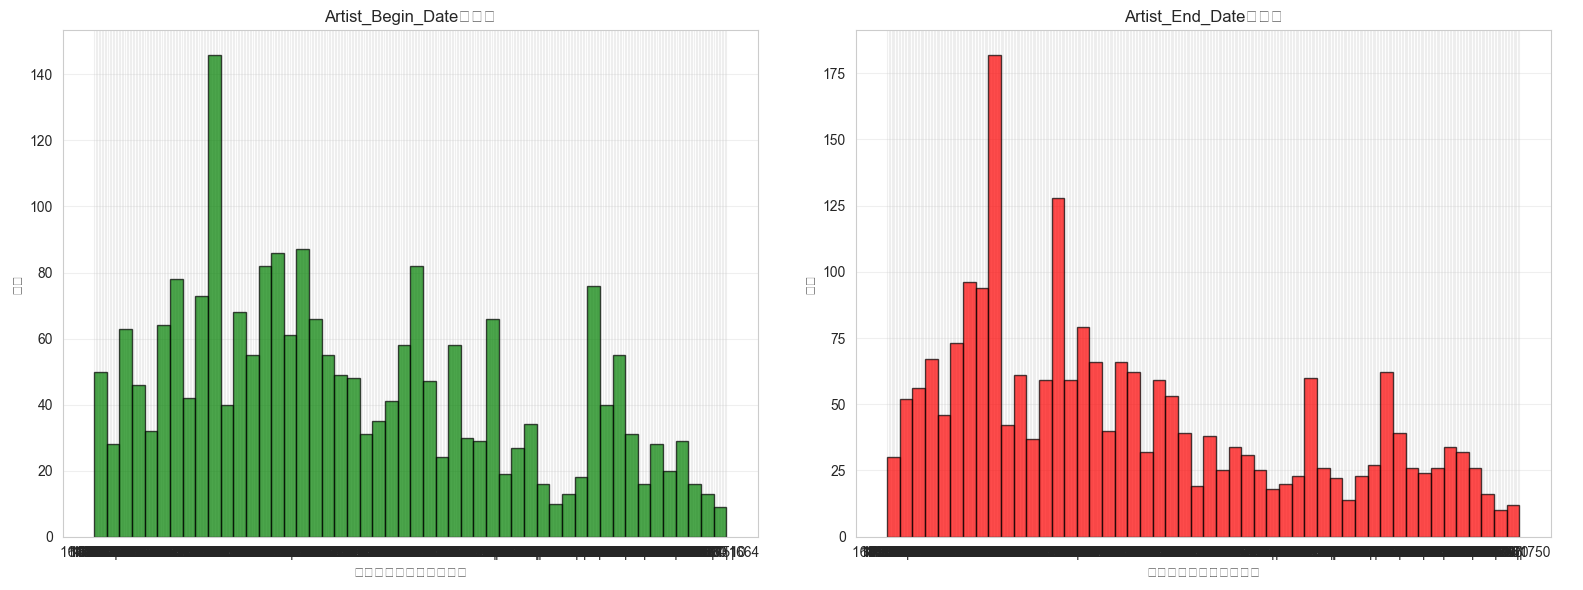

In [61]:
# アーティスト活動期間の分布
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Artist_Begin_Dateの分布
valid_artist_begin = df['Artist_Begin_Date'].dropna()
if len(valid_artist_begin) > 0:
    axes[0].hist(valid_artist_begin, bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[0].set_xlabel('アーティスト活動開始年')
    axes[0].set_ylabel('人数')
    axes[0].set_title('Artist_Begin_Dateの分布')
    axes[0].grid(True, alpha=0.3)

# Artist_End_Dateの分布
valid_artist_end = df['Artist_End_Date'].dropna()
if len(valid_artist_end) > 0:
    axes[1].hist(valid_artist_end, bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[1].set_xlabel('アーティスト活動終了年')
    axes[1].set_ylabel('人数')
    axes[1].set_title('Artist_End_Dateの分布')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## セクション4: メディア分析


In [62]:
# メディア（Medium）の分析
medium_counts = df['Medium'].value_counts()
medium_percent = (medium_counts / len(df)) * 100

print("=" * 60)
print(f"メディアの概要（{len(medium_counts)}種類のメディア）")
print("=" * 60)
print(f"欠損値: {df['Medium'].isnull().sum():,}件 ({df['Medium'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n上位20のメディア:")
medium_top20 = pd.DataFrame({
    '作品数': medium_counts.head(20),
    '割合(%)': medium_percent.head(20)
})
print(medium_top20)


メディアの概要（129種類のメディア）
欠損値: 0件 (0.0%)

上位20のメディア:
                                           作品数      割合(%)
Medium                                                   
Oil on canvas                             1207  52.707424
Oil on wood                                430  18.777293
Tempera on wood, gold ground               101   4.410480
Oil on paper, laid down on canvas           88   3.842795
Tempera on wood                             55   2.401747
Tempera and gold on wood                    52   2.270742
Oil on copper                               31   1.353712
Oil on paper                                30   1.310044
Oil on paper, laid down on cardboard        22   0.960699
Oil on canvas, transferred from wood        16   0.698690
Oil on oak                                  15   0.655022
Fresco, transferred to canvas               14   0.611354
Oil on paper, laid down on wood             12   0.524017
Oil and gold on wood                        11   0.480349
Oil and gold on oak      

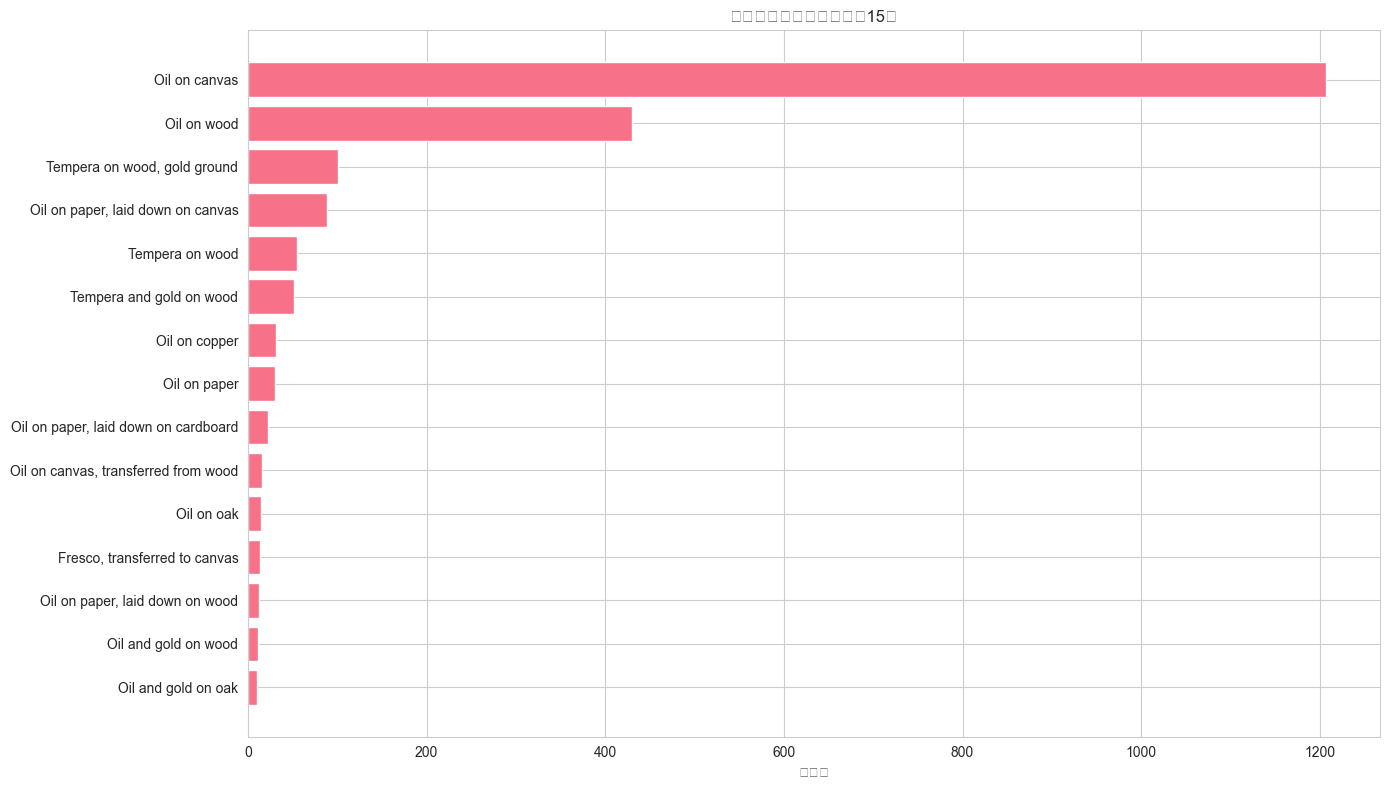

In [63]:
# メディアの分布を可視化（上位15）
plt.figure(figsize=(14, 8))
top_mediums = medium_counts.head(15)
# 長いメディア名を短縮
labels = [m[:50] + '...' if len(m) > 50 else m for m in top_mediums.index]
plt.barh(range(len(top_mediums)), top_mediums.values)
plt.yticks(range(len(top_mediums)), labels)
plt.xlabel('作品数')
plt.title('メディア別作品数（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [64]:
# メディアと文化圏のクロス集計（主要メディアのみ）
top_mediums_list = medium_counts.head(10).index.tolist()
medium_culture_cross = pd.crosstab(
    df[df['Medium'].isin(top_mediums_list)]['Medium'],
    df[df['Medium'].isin(top_mediums_list)]['Culture'],
    margins=True
)
print("=" * 60)
print("メディアと文化圏のクロス集計（主要メディア）")
print("=" * 60)
print(medium_culture_cross.loc[top_mediums_list].sort_values('All', ascending=False))


メディアと文化圏のクロス集計（主要メディア）


KeyError: "None of [Index(['Oil on canvas', 'Oil on wood', 'Tempera on wood, gold ground',\n       'Oil on paper, laid down on canvas', 'Tempera on wood',\n       'Tempera and gold on wood', 'Oil on copper', 'Oil on paper',\n       'Oil on paper, laid down on cardboard',\n       'Oil on canvas, transferred from wood'],\n      dtype='object', name='Medium')] are in the [index]"

## セクション5: アーティスト分析


In [66]:
# アーティスト名の分析
artist_counts = df['Artist_Display_Name'].value_counts()
artist_percent = (artist_counts / len(df)) * 100

print("=" * 60)
print(f"アーティストの概要（{len(artist_counts)}人のアーティスト）")
print("=" * 60)
print(f"欠損値: {df['Artist_Display_Name'].isnull().sum():,}件 ({df['Artist_Display_Name'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n上位20のアーティスト:")
artist_top20 = pd.DataFrame({
    '作品数': artist_counts.head(20),
    '割合(%)': artist_percent.head(20)
})
print(artist_top20)


アーティストの概要（974人のアーティスト）
欠損値: 0件 (0.0%)

上位20のアーティスト:
                                作品数     割合(%)
Artist_Display_Name                          
Claude Monet                     39  1.703057
Camille Corot                    35  1.528384
Gustave Courbet                  31  1.353712
Paul Cézanne                     23  1.004367
French Painter                   23  1.004367
Auguste Renoir                   22  0.960699
Edouard Manet                    22  0.960699
Edgar Degas                      21  0.917031
Giovanni Battista Tiepolo        21  0.917031
Rembrandt (Rembrandt van Rijn)   19  0.829694
Camille Pissarro                 19  0.829694
Peter Paul Rubens                18  0.786026
Corneille de Lyon                17  0.742358
Rembrandt                        17  0.742358
Vincent van Gogh                 17  0.742358
Anthony van Dyck                 14  0.611354
Russian Painter                  13  0.567686
Francesco Guardi                 13  0.567686
Frans Hals                  

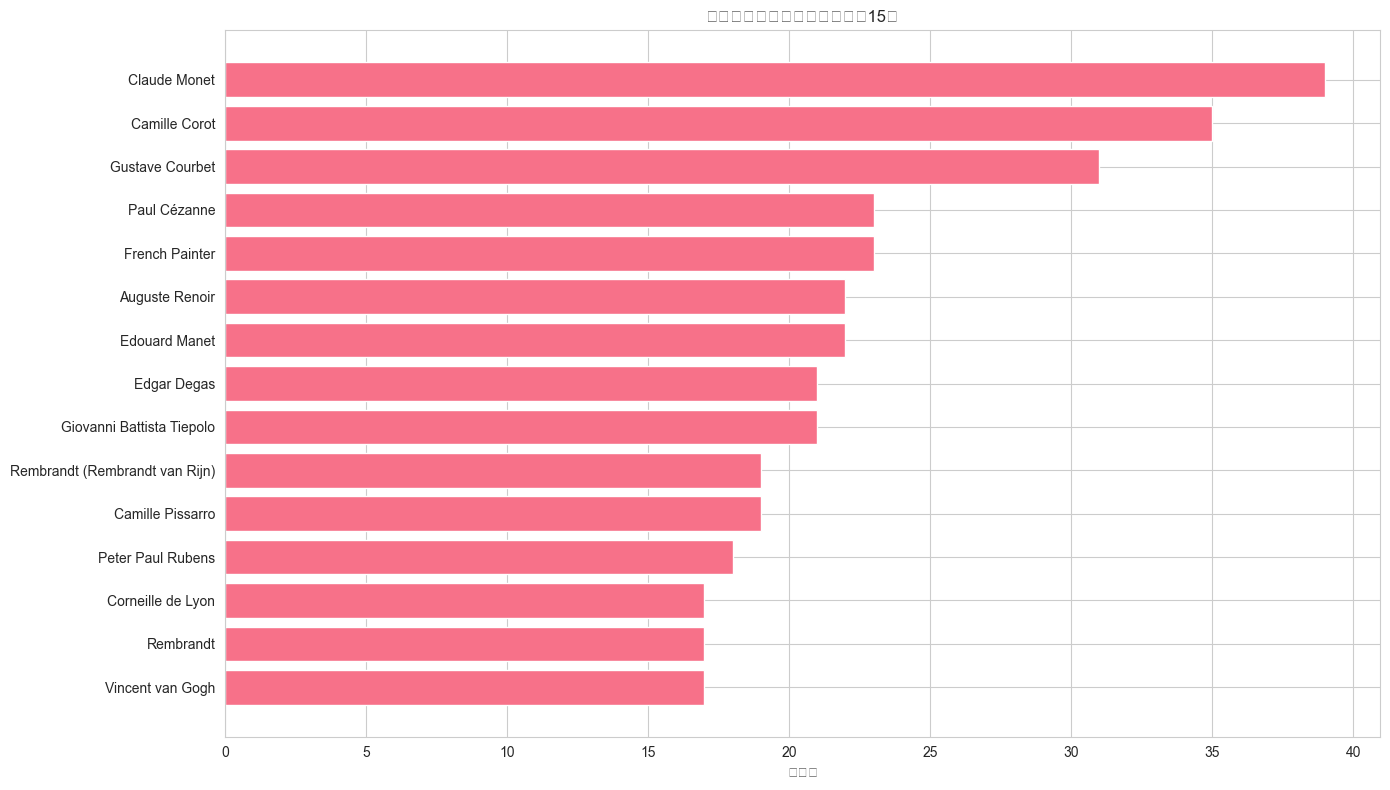

In [67]:
# アーティストの分布を可視化（上位15）
plt.figure(figsize=(14, 8))
top_artists = artist_counts.head(15)
# 長いアーティスト名を短縮
labels = [a[:40] + '...' if len(a) > 40 else a for a in top_artists.index]
plt.barh(range(len(top_artists)), top_artists.values)
plt.yticks(range(len(top_artists)), labels)
plt.xlabel('作品数')
plt.title('アーティスト別作品数（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [68]:
# アーティストの国籍分析
nationality_counts = df['Artist_Nationality'].value_counts()
nationality_percent = (nationality_counts / len(df)) * 100

print("=" * 60)
print(f"アーティスト国籍の概要（{len(nationality_counts)}種類の国籍）")
print("=" * 60)
print(f"欠損値: {df['Artist_Nationality'].isnull().sum():,}件 ({df['Artist_Nationality'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n上位20の国籍:")
nationality_top20 = pd.DataFrame({
    '人数': nationality_counts.head(20),
    '割合(%)': nationality_percent.head(20)
})
print(nationality_top20)


アーティスト国籍の概要（41種類の国籍）
欠損値: 0件 (0.0%)

上位20の国籍:
                     人数      割合(%)
Artist_Nationality                
French              768  33.537118
Italian             514  22.445415
Dutch               242  10.567686
Netherlandish       146   6.375546
German              132   5.764192
British             124   5.414847
Flemish              96   4.192140
Spanish              74   3.231441
Norwegian            22   0.960699
Danish               21   0.917031
Russian              20   0.873362
Swiss                18   0.786026
Greek                14   0.611354
Belgian              14   0.611354
British, Scottish    13   0.567686
Austrian             12   0.524017
Swedish              11   0.480349
Italian|Italian       5   0.218341
Flemish|Flemish       5   0.218341
                      4   0.174672


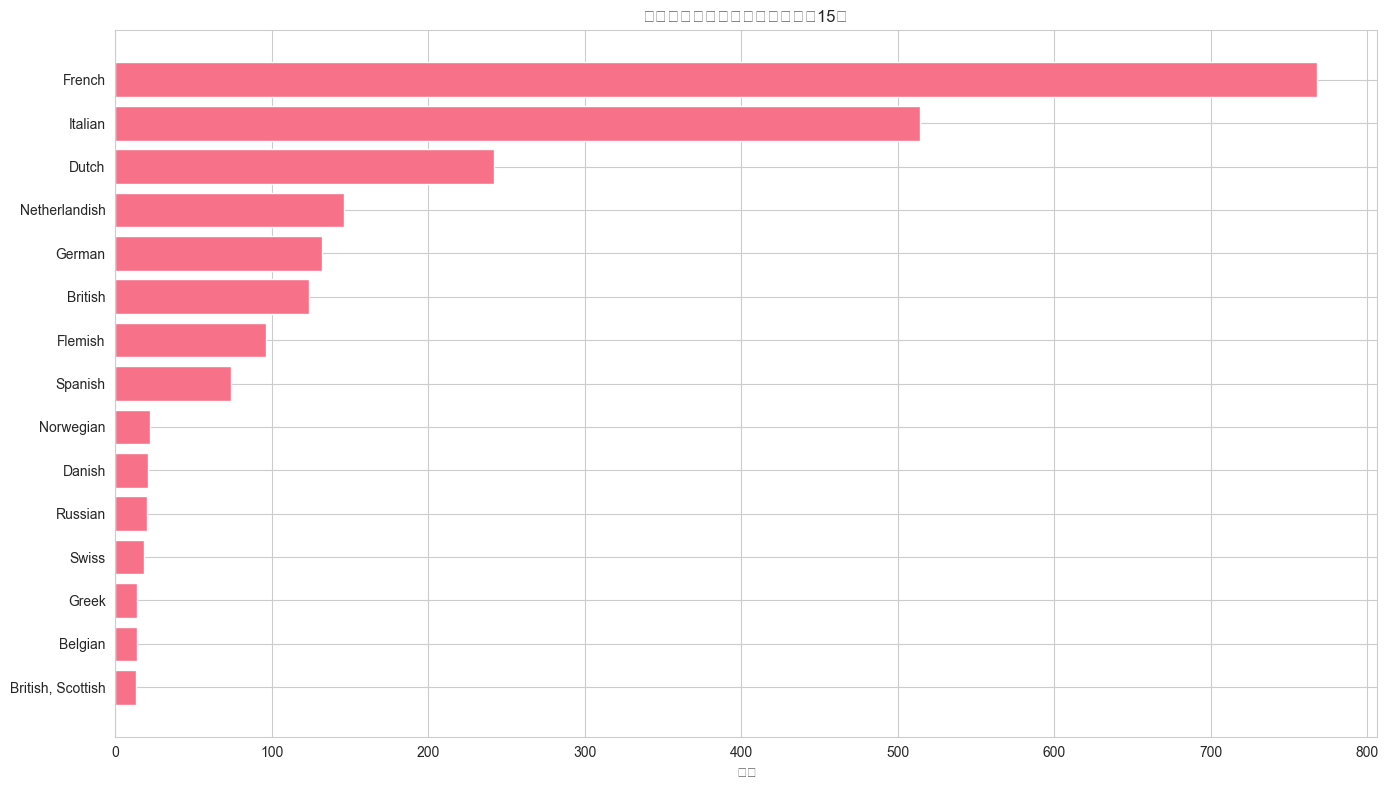

In [69]:
# アーティストの国籍分布を可視化（上位15）
plt.figure(figsize=(14, 8))
top_nationalities = nationality_counts.head(15)
plt.barh(range(len(top_nationalities)), top_nationalities.values)
plt.yticks(range(len(top_nationalities)), top_nationalities.index)
plt.xlabel('人数')
plt.title('アーティスト国籍別人数（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


アーティスト性別の概要
欠損値: 2,239件 (97.8%)

性別分布:
               人数     割合(%)
Artist_Gender              
Female         32  1.397380
|              18  0.786026
|Female         1  0.043668


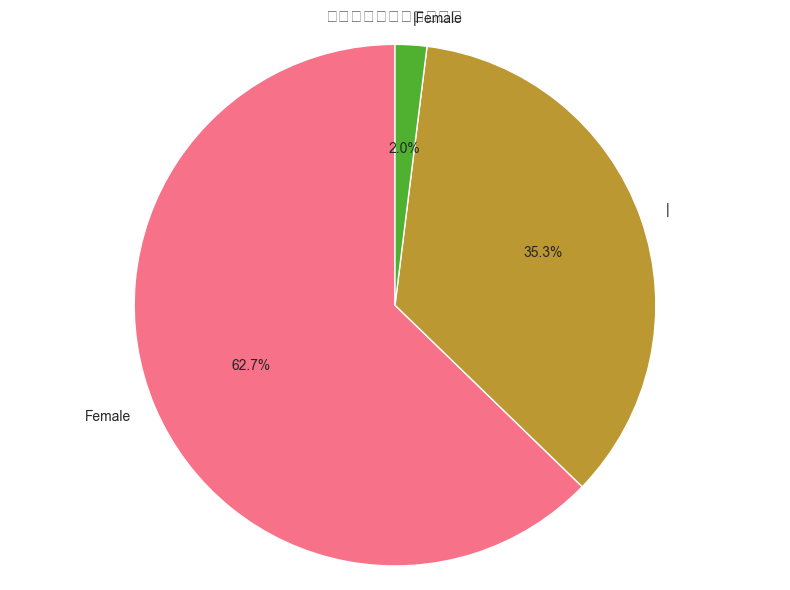

In [70]:
# アーティストの性別分析
gender_counts = df['Artist_Gender'].value_counts()
gender_percent = (gender_counts / len(df)) * 100

print("=" * 60)
print("アーティスト性別の概要")
print("=" * 60)
print(f"欠損値: {df['Artist_Gender'].isnull().sum():,}件 ({df['Artist_Gender'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n性別分布:")
gender_df = pd.DataFrame({
    '人数': gender_counts,
    '割合(%)': gender_percent
})
print(gender_df)

# 性別分布を可視化
plt.figure(figsize=(8, 6))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('アーティスト性別の分布')
plt.axis('equal')
plt.tight_layout()
plt.show()


## セクション6: Department分析


In [71]:
# Departmentの分析
dept_counts = df['Department'].value_counts()
dept_percent = (dept_counts / len(df)) * 100

print("=" * 60)
print(f"Departmentの概要（{len(dept_counts)}種類のDepartment）")
print("=" * 60)
print(f"欠損値: {df['Department'].isnull().sum():,}件 ({df['Department'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n全Department:")
dept_df = pd.DataFrame({
    '作品数': dept_counts,
    '割合(%)': dept_percent
})
print(dept_df)


Departmentの概要（1種類のDepartment）
欠損値: 0件 (0.0%)

全Department:
                     作品数  割合(%)
Department                     
European Paintings  2290  100.0


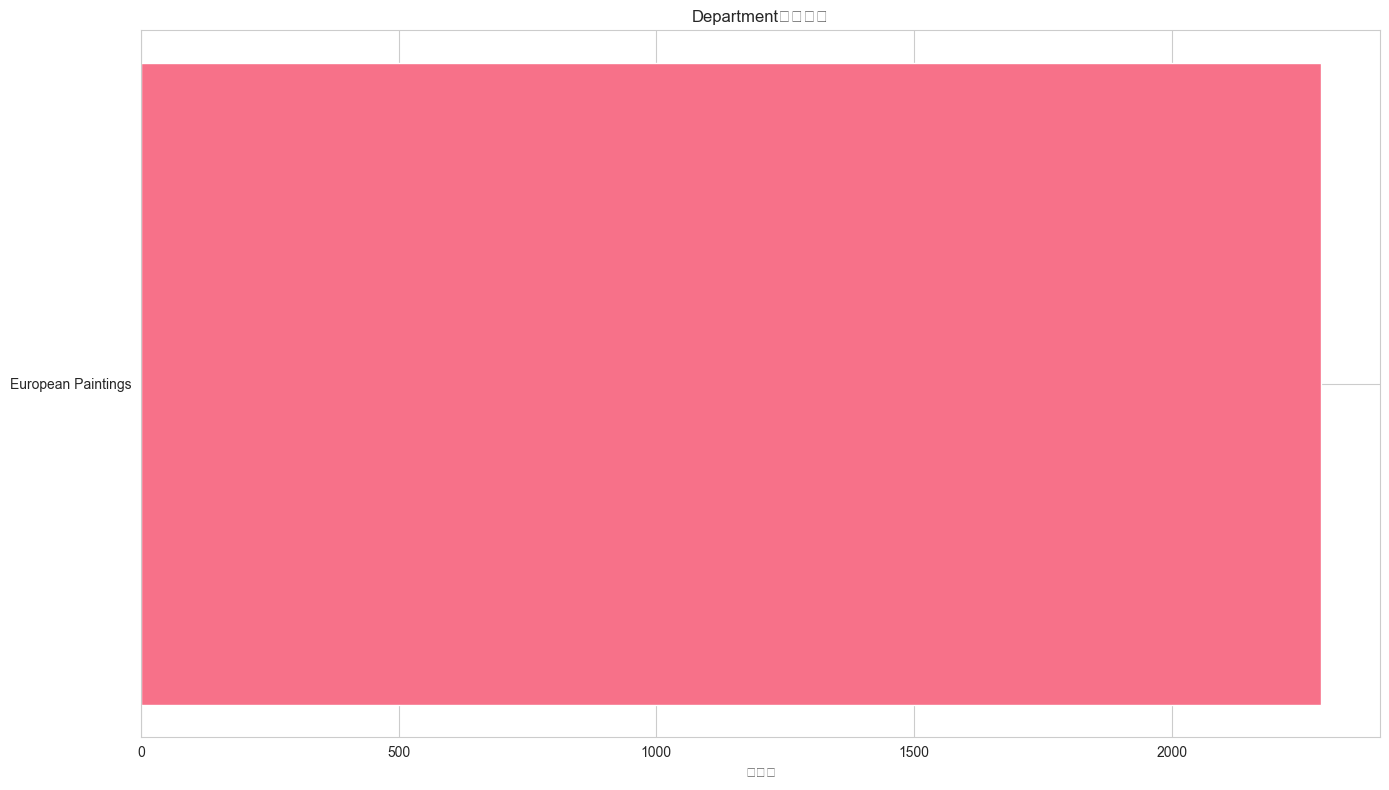

In [72]:
# Departmentの分布を可視化
plt.figure(figsize=(14, 8))
plt.barh(range(len(dept_counts)), dept_counts.values)
plt.yticks(range(len(dept_counts)), dept_counts.index)
plt.xlabel('作品数')
plt.title('Department別作品数')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [73]:
# Departmentと文化圏の関係（ヒートマップ）
dept_culture_cross = pd.crosstab(df['Department'], df['Culture'])
# 上位文化圏のみ抽出
top_cultures_list = culture_counts.head(15).index.tolist()
dept_culture_top = dept_culture_cross[top_cultures_list]

plt.figure(figsize=(16, 10))
sns.heatmap(dept_culture_top, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': '作品数'})
plt.title('Departmentと文化圏のクロス集計（上位15文化圏）')
plt.xlabel('文化圏')
plt.ylabel('Department')
plt.tight_layout()
plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1600x1000 with 0 Axes>

## セクション7: タグ分析（JSON解析）


In [90]:
# タグ列のJSON解析
def parse_tags(tags_str):
    """tags列をJSONとして解析してタグリストを返す"""
    if pd.isna(tags_str) or tags_str == '':
        return []
    try:
        if isinstance(tags_str, str):
            tags_data = json.loads(tags_str)
        else:
            tags_data = tags_str
        if isinstance(tags_data, list):
            # API形式の場合: [{"term": "...", ...}, ...]
            return [tag.get('term', '') for tag in tags_data if isinstance(tag, dict) and 'term' in tag]
        elif isinstance(tags_data, dict):
            # 単一タグの場合
            return [tags_data.get('term', '')] if 'term' in tags_data else []
        else:
            return []
    except (json.JSONDecodeError, TypeError):
        return []

# 全タグを抽出
print("タグ列の解析を開始...")
all_tags = []
tags_count = 0

for idx, tags_str in enumerate(df['tags']):
    if idx % 1000 == 0 and idx > 0:
        print(f"  処理中: {idx:,} / {len(df):,}行")
    tags_list = parse_tags(tags_str)
    all_tags.extend(tags_list)
    if tags_list:
        tags_count += 1

print(f"\n解析完了:")
print(f"  タグが存在する作品数: {tags_count:,}件 ({tags_count / len(df) * 100:.1f}%)")
print(f"  抽出されたタグの総数: {len(all_tags):,}個")
print(f"  ユニークなタグ数: {len(set(all_tags)):,}個")


タグ列の解析を開始...
  処理中: 1,000 / 2,290行
  処理中: 2,000 / 2,290行

解析完了:
  タグが存在する作品数: 2,281件 (99.6%)
  抽出されたタグの総数: 7,288個
  ユニークなタグ数: 570個


In [91]:
# 頻出タグの分析
tag_counter = Counter(all_tags)
tag_counts = pd.Series(dict(tag_counter.most_common()))

print("=" * 60)
print(f"頻出タグ（上位30）")
print("=" * 60)
tag_df = pd.DataFrame({
    '出現回数': tag_counts.head(30),
    '割合(%)': (tag_counts.head(30) / len(df) * 100).round(2)
})
print(tag_df)


頻出タグ（上位30）
                        出現回数  割合(%)
Men                      838  36.59
Women                    682  29.78
Portraits                559  24.41
Landscapes               260  11.35
Christ                   149   6.51
Dogs                     146   6.38
Virgin Mary              142   6.20
Madonna and Child        136   5.94
Angels                   127   5.55
Saints                   121   5.28
Horses                   116   5.07
Boats                     87   3.80
Interiors                 86   3.76
Still Life                86   3.76
Rivers                    79   3.45
Female Nudes              72   3.14
Girls                     65   2.84
Boys                      64   2.79
Jesus                     57   2.49
Saint John the Baptist    55   2.40
Flowers                   50   2.18
Soldiers                  47   2.05
Rome                      47   2.05
Cows                      42   1.83
Orientalist               41   1.79
Children                  41   1.79
Forests          

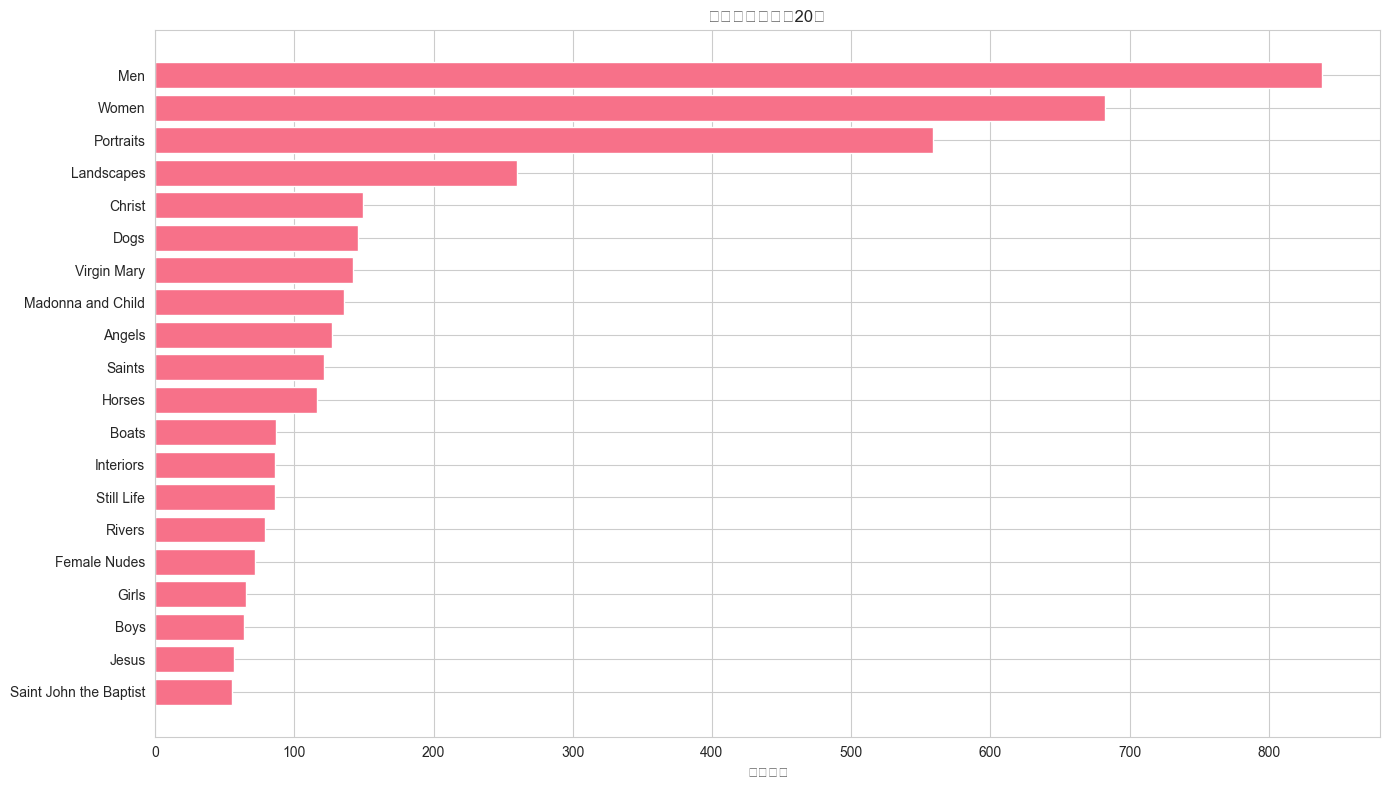

In [92]:
# 頻出タグの可視化（上位20）
plt.figure(figsize=(14, 8))
top_tags = tag_counts.head(20)
plt.barh(range(len(top_tags)), top_tags.values)
plt.yticks(range(len(top_tags)), top_tags.index)
plt.xlabel('出現回数')
plt.title('頻出タグ（上位20）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


作品あたりのタグ数の統計
count    2290.000000
mean        3.182533
std         1.610323
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
dtype: float64


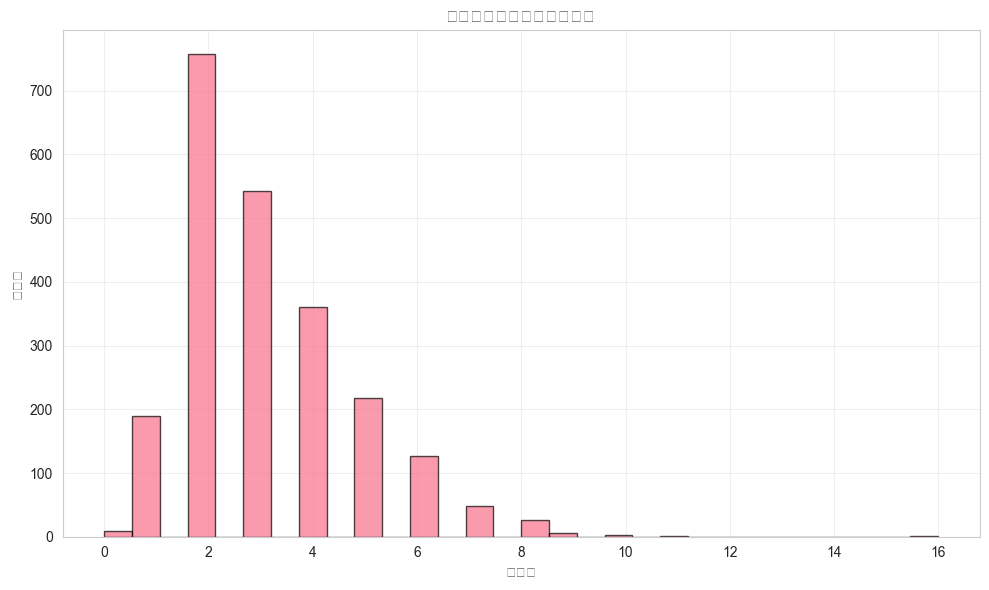

In [93]:
# 作品あたりのタグ数の分布
tags_per_artwork = []
for tags_str in df['tags']:
    tags_list = parse_tags(tags_str)
    tags_per_artwork.append(len(tags_list))

tags_per_artwork_series = pd.Series(tags_per_artwork)

print("=" * 60)
print("作品あたりのタグ数の統計")
print("=" * 60)
print(tags_per_artwork_series.describe())

plt.figure(figsize=(10, 6))
plt.hist(tags_per_artwork_series, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('タグ数')
plt.ylabel('作品数')
plt.title('作品あたりのタグ数の分布')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## セクション8: Constituents分析（JSON解析）


In [94]:
# Constituents列のJSON解析
def parse_constituents(constituents_str):
    """constituents列をJSONとして解析してリストを返す"""
    if pd.isna(constituents_str) or constituents_str == '':
        return []
    try:
        if isinstance(constituents_str, str):
            constituents_data = json.loads(constituents_str)
        else:
            constituents_data = constituents_str
        if isinstance(constituents_data, list):
            return constituents_data
        elif isinstance(constituents_data, dict):
            return [constituents_data]
        else:
            return []
    except (json.JSONDecodeError, TypeError):
        return []

# Constituentsの分析
print("Constituents列の解析を開始...")
all_roles = []
all_genders = []
constituents_count = 0
constituents_per_artwork = []

for idx, constituents_str in enumerate(df['constituents']):
    if idx % 1000 == 0 and idx > 0:
        print(f"  処理中: {idx:,} / {len(df):,}行")
    constituents_list = parse_constituents(constituents_str)
    constituents_per_artwork.append(len(constituents_list))
    if constituents_list:
        constituents_count += 1
        for const in constituents_list:
            if isinstance(const, dict):
                if 'role' in const:
                    all_roles.append(const['role'])
                if 'gender' in const and const['gender']:
                    all_genders.append(const['gender'])

print(f"\n解析完了:")
print(f"  Constituentsが存在する作品数: {constituents_count:,}件 ({constituents_count / len(df) * 100:.1f}%)")
print(f"  抽出されたロール数: {len(all_roles):,}個")
print(f"  抽出された性別情報数: {len(all_genders):,}個")


Constituents列の解析を開始...
  処理中: 1,000 / 2,290行
  処理中: 2,000 / 2,290行

解析完了:
  Constituentsが存在する作品数: 2,284件 (99.7%)
  抽出されたロール数: 2,303個
  抽出された性別情報数: 34個


アーティストロールの分布（上位20）
        出現回数  割合(%)
Artist  2303  100.0


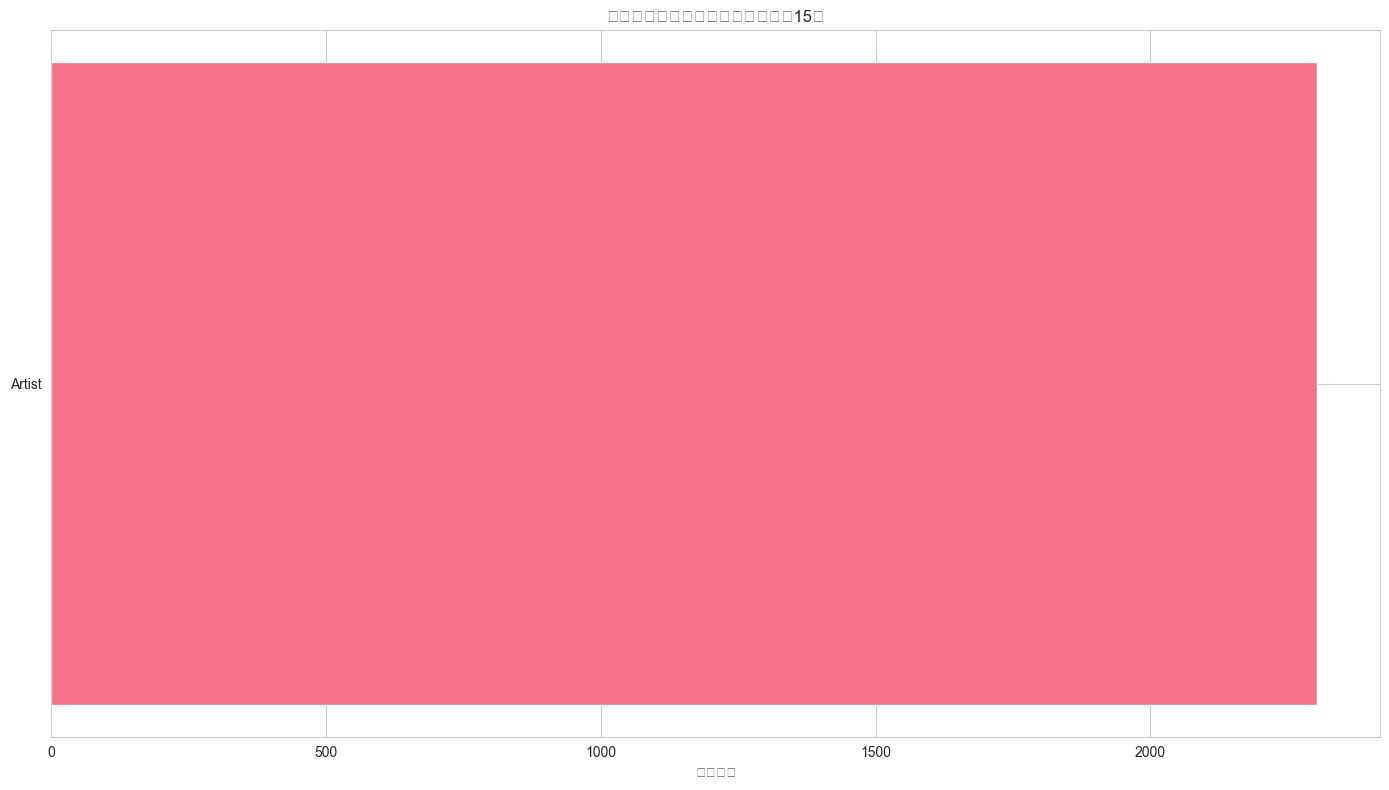

In [95]:
# アーティストロールの分析
role_counter = Counter(all_roles)
role_counts = pd.Series(dict(role_counter.most_common()))

print("=" * 60)
print(f"アーティストロールの分布（上位20）")
print("=" * 60)
role_df = pd.DataFrame({
    '出現回数': role_counts.head(20),
    '割合(%)': (role_counts.head(20) / len(all_roles) * 100).round(2) if len(all_roles) > 0 else 0
})
print(role_df)

# ロールの可視化
plt.figure(figsize=(14, 8))
top_roles = role_counts.head(15)
plt.barh(range(len(top_roles)), top_roles.values)
plt.yticks(range(len(top_roles)), top_roles.index)
plt.xlabel('出現回数')
plt.title('アーティストロールの分布（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Constituents内の性別分布
        人数  割合(%)
Female  34  100.0


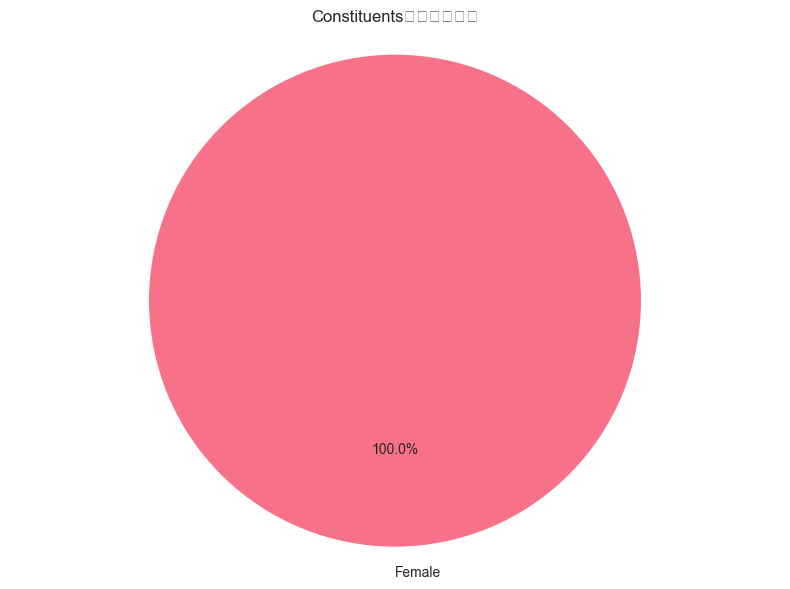

In [96]:
# Constituents内の性別分布
if len(all_genders) > 0:
    gender_counter = Counter(all_genders)
    gender_counts_const = pd.Series(dict(gender_counter.most_common()))
    
    print("=" * 60)
    print("Constituents内の性別分布")
    print("=" * 60)
    gender_const_df = pd.DataFrame({
        '人数': gender_counts_const,
        '割合(%)': (gender_counts_const / len(all_genders) * 100).round(2)
    })
    print(gender_const_df)
    
    # 性別分布を可視化
    plt.figure(figsize=(8, 6))
    plt.pie(gender_counts_const.values, labels=gender_counts_const.index, autopct='%1.1f%%', startangle=90)
    plt.title('Constituents内の性別分布')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("性別情報が見つかりませんでした")


作品あたりのConstituents数の統計
count    2290.000000
mean        1.005677
std         0.104353
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
dtype: float64


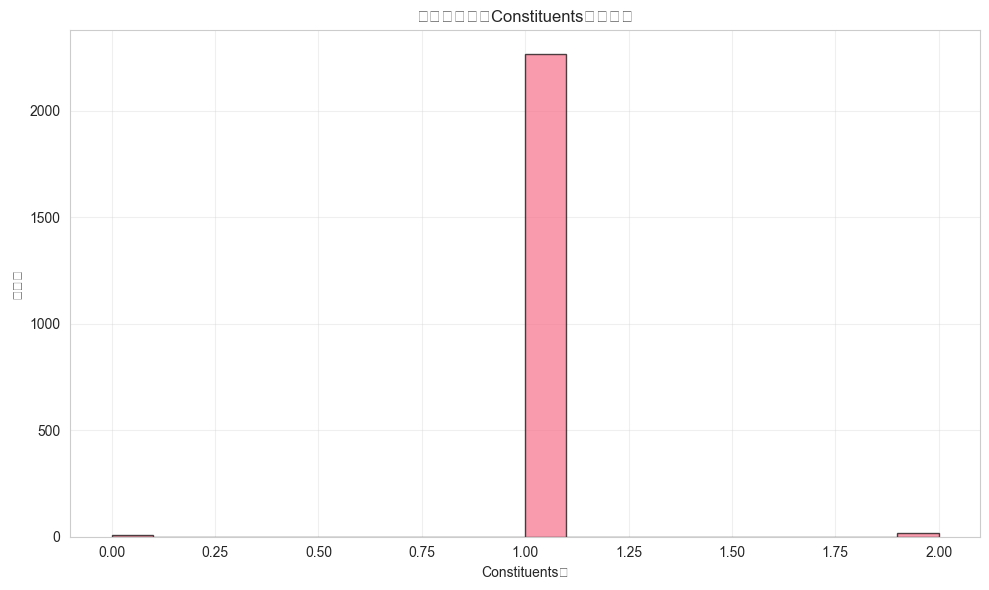

In [97]:
# 作品あたりのConstituents数の分布
constituents_per_artwork_series = pd.Series(constituents_per_artwork)

print("=" * 60)
print("作品あたりのConstituents数の統計")
print("=" * 60)
print(constituents_per_artwork_series.describe())

plt.figure(figsize=(10, 6))
plt.hist(constituents_per_artwork_series, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Constituents数')
plt.ylabel('作品数')
plt.title('作品あたりのConstituents数の分布')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## セクション9: 測定値分析（JSON解析）


In [98]:
# Measurements列のJSON解析
def parse_measurements(measurements_str):
    """measurements列をJSONとして解析してリストを返す"""
    if pd.isna(measurements_str) or measurements_str == '':
        return []
    try:
        if isinstance(measurements_str, str):
            measurements_data = json.loads(measurements_str)
        else:
            measurements_data = measurements_str
        if isinstance(measurements_data, list):
            return measurements_data
        elif isinstance(measurements_data, dict):
            return [measurements_data]
        else:
            return []
    except (json.JSONDecodeError, TypeError):
        return []

def extract_dimensions(measurements_data):
    """measurementsデータからHeightとWidthを抽出"""
    heights = []
    widths = []
    depths = []
    
    for measure in measurements_data:
        if isinstance(measure, dict) and 'elementMeasurements' in measure:
            elem_measure = measure['elementMeasurements']
            if isinstance(elem_measure, dict):
                if 'Height' in elem_measure:
                    try:
                        heights.append(float(elem_measure['Height']))
                    except (ValueError, TypeError):
                        pass
                if 'Width' in elem_measure:
                    try:
                        widths.append(float(elem_measure['Width']))
                    except (ValueError, TypeError):
                        pass
                if 'Depth' in elem_measure:
                    try:
                        depths.append(float(elem_measure['Depth']))
                    except (ValueError, TypeError):
                        pass
    
    return heights, widths, depths

# Measurementsの分析
print("Measurements列の解析を開始...")
all_heights = []
all_widths = []
all_depths = []
measurements_count = 0

for idx, measurements_str in enumerate(df['measurements']):
    if idx % 1000 == 0 and idx > 0:
        print(f"  処理中: {idx:,} / {len(df):,}行")
    measurements_data = parse_measurements(measurements_str)
    if measurements_data:
        measurements_count += 1
        heights, widths, depths = extract_dimensions(measurements_data)
        all_heights.extend(heights)
        all_widths.extend(widths)
        all_depths.extend(depths)

print(f"\n解析完了:")
print(f"  Measurementsが存在する作品数: {measurements_count:,}件 ({measurements_count / len(df) * 100:.1f}%)")
print(f"  抽出されたHeight値: {len(all_heights):,}個")
print(f"  抽出されたWidth値: {len(all_widths):,}個")
print(f"  抽出されたDepth値: {len(all_depths):,}個")


Measurements列の解析を開始...
  処理中: 1,000 / 2,290行
  処理中: 2,000 / 2,290行

解析完了:
  Measurementsが存在する作品数: 2,282件 (99.7%)
  抽出されたHeight値: 3,426個
  抽出されたWidth値: 3,429個
  抽出されたDepth値: 994個


作品サイズの統計（cm単位）

Height（高さ）:
count    3426.000000
mean       82.988162
std        57.757909
min         8.600000
25%        41.902521
50%        69.200000
75%       105.410200
max       558.800000
dtype: float64

Width（幅）:
count    3429.000000
mean       80.445712
std        56.532069
min         3.810008
25%        41.000000
50%        66.000000
75%       102.900000
max       532.766050
dtype: float64


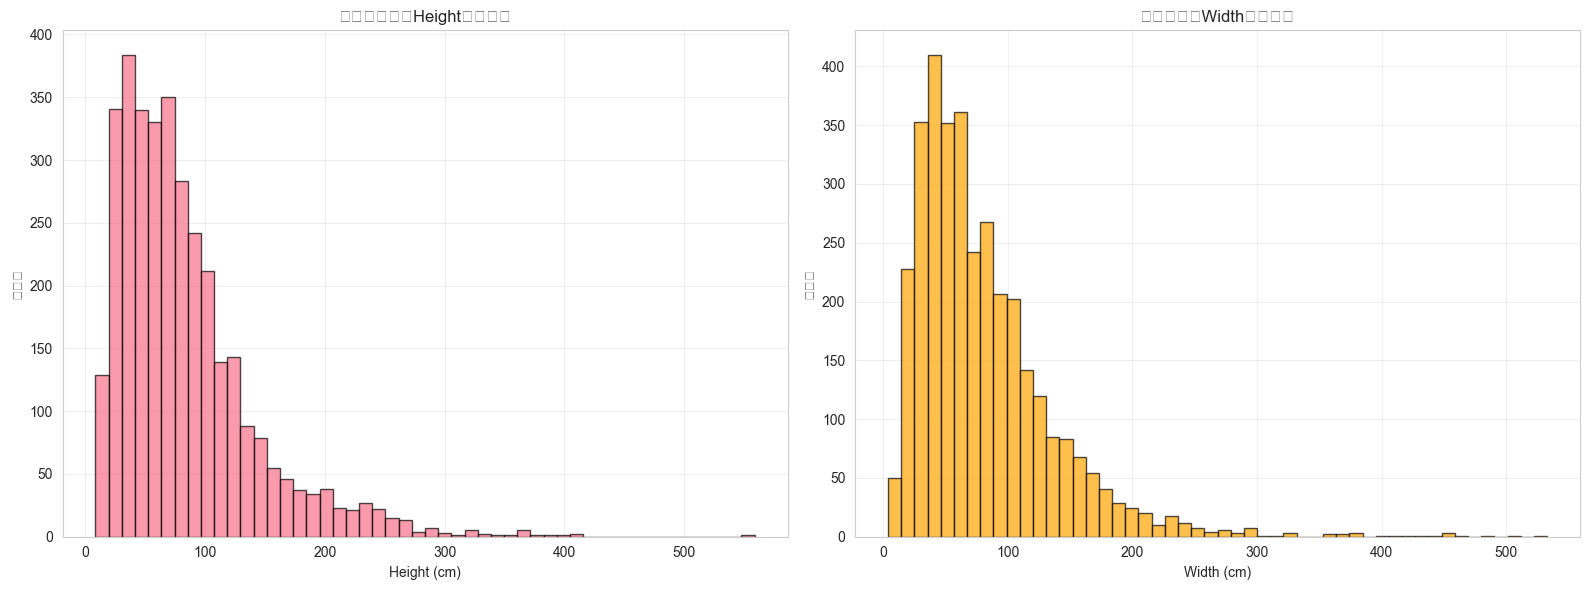

In [99]:
# 作品サイズの分析
if len(all_heights) > 0 and len(all_widths) > 0:
    heights_series = pd.Series(all_heights)
    widths_series = pd.Series(all_widths)
    
    print("=" * 60)
    print("作品サイズの統計（cm単位）")
    print("=" * 60)
    print("\nHeight（高さ）:")
    print(heights_series.describe())
    print("\nWidth（幅）:")
    print(widths_series.describe())
    
    # サイズの分布を可視化
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heightの分布
    axes[0].hist(heights_series, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Height (cm)')
    axes[0].set_ylabel('作品数')
    axes[0].set_title('作品の高さ（Height）の分布')
    axes[0].grid(True, alpha=0.3)
    
    # Widthの分布
    axes[1].hist(widths_series, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_xlabel('Width (cm)')
    axes[1].set_ylabel('作品数')
    axes[1].set_title('作品の幅（Width）の分布')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("サイズデータが見つかりませんでした")


アスペクト比（幅/高さ）の統計
count    3426.000000
mean        1.232265
std         1.084408
min         0.031403
25%         0.694762
50%         0.915233
75%         1.430072
max        15.045526
dtype: float64


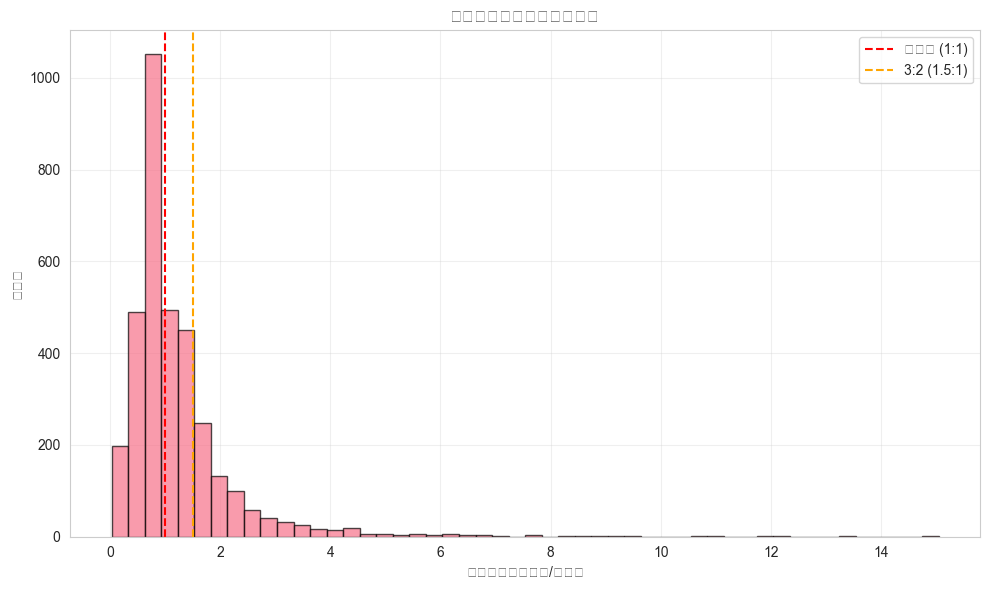

In [100]:
# アスペクト比の分析
if len(all_heights) > 0 and len(all_widths) > 0:
    # HeightとWidthのペアを作成（同じインデックスのものをペアにする）
    min_len = min(len(all_heights), len(all_widths))
    heights_paired = all_heights[:min_len]
    widths_paired = all_widths[:min_len]
    
    # アスペクト比を計算（幅/高さ）
    aspect_ratios = [w/h if h > 0 else np.nan for h, w in zip(heights_paired, widths_paired)]
    aspect_ratios_series = pd.Series(aspect_ratios).dropna()
    
    print("=" * 60)
    print("アスペクト比（幅/高さ）の統計")
    print("=" * 60)
    print(aspect_ratios_series.describe())
    
    # アスペクト比の分布を可視化
    plt.figure(figsize=(10, 6))
    plt.hist(aspect_ratios_series, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('アスペクト比（幅/高さ）')
    plt.ylabel('作品数')
    plt.title('作品のアスペクト比の分布')
    plt.axvline(1.0, color='red', linestyle='--', label='正方形 (1:1)')
    plt.axvline(1.5, color='orange', linestyle='--', label='3:2 (1.5:1)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("アスペクト比を計算するためのデータが不足しています")


## セクション10: 画像データ分析


画像ダウンロード状況
画像ダウンロード済み: 2,007件 (87.6%)
画像ダウンロード未済: 283件 (12.4%)


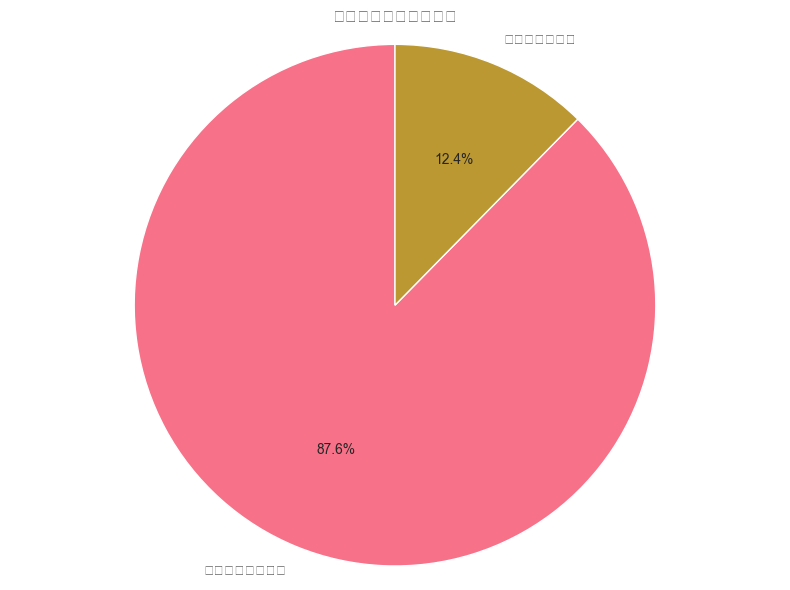

In [85]:
# 画像ダウンロード状況の分析
image_downloaded_counts = df['image_downloaded'].value_counts()
image_downloaded_percent = (image_downloaded_counts / len(df)) * 100

print("=" * 60)
print("画像ダウンロード状況")
print("=" * 60)
print(f"画像ダウンロード済み: {image_downloaded_counts.get(True, 0):,}件 ({image_downloaded_percent.get(True, 0):.1f}%)")
print(f"画像ダウンロード未済: {image_downloaded_counts.get(False, 0):,}件 ({image_downloaded_percent.get(False, 0):.1f}%)")

# 可視化
plt.figure(figsize=(8, 6))
plt.pie(image_downloaded_counts.values, labels=['ダウンロード済み' if k else '未ダウンロード' for k in image_downloaded_counts.index], 
        autopct='%1.1f%%', startangle=90)
plt.title('画像ダウンロード状況')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [86]:
# primaryImageSmallの有無
primary_image_small_has = df['primaryImageSmall'].notna().sum()
primary_image_small_percent = (primary_image_small_has / len(df)) * 100

print("=" * 60)
print("primaryImageSmallの有無")
print("=" * 60)
print(f"primaryImageSmallあり: {primary_image_small_has:,}件 ({primary_image_small_percent:.1f}%)")
print(f"primaryImageSmallなし: {len(df) - primary_image_small_has:,}件 ({100 - primary_image_small_percent:.1f}%)")

# additionalImagesの有無
additional_images_has = df['additionalImages'].notna().sum()
additional_images_percent = (additional_images_has / len(df)) * 100

print(f"\nadditionalImagesあり: {additional_images_has:,}件 ({additional_images_percent:.1f}%)")
print(f"additionalImagesなし: {len(df) - additional_images_has:,}件 ({100 - additional_images_percent:.1f}%)")


primaryImageSmallの有無
primaryImageSmallあり: 2,007件 (87.6%)
primaryImageSmallなし: 283件 (12.4%)

additionalImagesあり: 2,284件 (99.7%)
additionalImagesなし: 6件 (0.3%)


In [87]:
# 画像URLの形式分析（primaryImageSmallのサンプル）
sample_image_urls = df['primaryImageSmall'].dropna().head(10)
print("=" * 60)
print("画像URLのサンプル（primaryImageSmall）")
print("=" * 60)
for i, url in enumerate(sample_image_urls, 1):
    print(f"{i:2d}. {url}")


画像URLのサンプル（primaryImageSmall）
 1. https://images.metmuseum.org/CRDImages/ep/web-large/DP102155.jpg
 2. https://images.metmuseum.org/CRDImages/ep/web-large/DT8028.jpg
 3. https://images.metmuseum.org/CRDImages/ep/web-large/DP318238.jpg
 4. https://images.metmuseum.org/CRDImages/ep/web-large/DP-19582-001.jpg
 5. https://images.metmuseum.org/CRDImages/ep/web-large/DP-20398-001.jpg
 6. https://images.metmuseum.org/CRDImages/ep/web-large/DT5285.jpg
 7. https://images.metmuseum.org/CRDImages/ep/web-large/DP369867.jpg
 8. https://images.metmuseum.org/CRDImages/ep/web-large/DT285189.jpg
 9. https://images.metmuseum.org/CRDImages/ep/web-large/DP120669.jpg
10. https://images.metmuseum.org/CRDImages/ep/web-large/ep41.190.9.bw.R.jpg


## セクション11: 総合分析と洞察


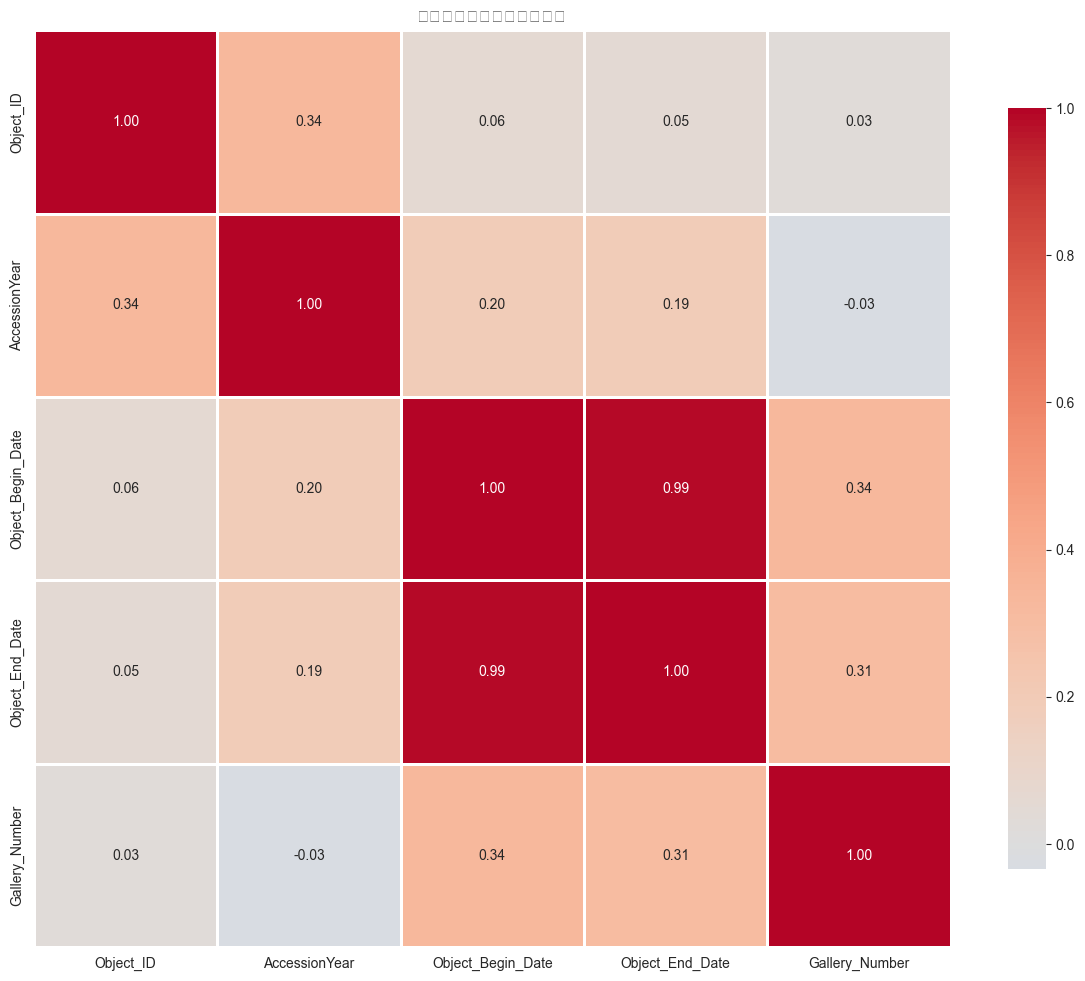

主要数値変数間の相関行列
                   Object_ID  AccessionYear  Object_Begin_Date  \
Object_ID           1.000000       0.335362           0.058069   
AccessionYear       0.335362       1.000000           0.195139   
Object_Begin_Date   0.058069       0.195139           1.000000   
Object_End_Date     0.050804       0.189031           0.987257   
Gallery_Number      0.026813      -0.034480           0.335854   

                   Object_End_Date  Gallery_Number  
Object_ID                 0.050804        0.026813  
AccessionYear             0.189031       -0.034480  
Object_Begin_Date         0.987257        0.335854  
Object_End_Date           1.000000        0.310542  
Gallery_Number            0.310542        1.000000  


In [88]:
# 主要変数間の相関分析（数値列のみ）
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# 重要な数値列を選択
important_numeric_cols = ['Object_ID', 'AccessionYear', 'Object_Begin_Date', 'Object_End_Date', 
                          'Artist_Begin_Date', 'Artist_End_Date', 'Gallery_Number']
available_numeric_cols = [col for col in important_numeric_cols if col in numeric_cols]

if len(available_numeric_cols) > 1:
    correlation_matrix = df[available_numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('主要数値変数間の相関行列')
    plt.tight_layout()
    plt.show()
    
    print("=" * 60)
    print("主要数値変数間の相関行列")
    print("=" * 60)
    print(correlation_matrix)
else:
    print("相関分析に十分な数値列がありません")


## 重要な洞察のまとめ

以下に、このEDAで得られた主要な洞察をまとめます。


In [89]:
# データ品質の評価
print("=" * 60)
print("データ品質の評価")
print("=" * 60)

# 主要列の欠損率
key_columns = ['Culture', 'Medium', 'Artist_Display_Name', 'Department', 
               'Object_Begin_Date', 'Object_End_Date', 'tags', 'constituents', 'measurements']

quality_report = []
for col in key_columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_percent = (missing_count / len(df)) * 100
        quality_report.append({
            '列名': col,
            '欠損数': missing_count,
            '欠損率(%)': f"{missing_percent:.1f}%",
            'データ品質': '良好' if missing_percent < 10 else '要改善' if missing_percent < 50 else '悪い'
        })

quality_df = pd.DataFrame(quality_report)
print(quality_df.to_string(index=False))


データ品質の評価
                 列名  欠損数 欠損率(%) データ品質
            Culture 2290 100.0%    悪い
             Medium    0   0.0%    良好
Artist_Display_Name    0   0.0%    良好
         Department    0   0.0%    良好
  Object_Begin_Date    0   0.0%    良好
    Object_End_Date    0   0.0%    良好
               tags    9   0.4%    良好
       constituents    6   0.3%    良好
       measurements    8   0.3%    良好
